In [36]:
import os 
import math
import matplotlib.pyplot as plt
import pandas as pd 
from matplotlib.patches import Rectangle



# ============================================================
# Utility
# ============================================================
def make_undirected(adj):
    g = {}
    for a, nbrs in adj.items():
        g.setdefault(a, set())
        for b in nbrs:
            g.setdefault(b, set())
            g[a].add(b)
            g[b].add(a)
    return {k: list(v) for k, v in g.items()}


def rect_from_center(cx, cy, w, h):
    return (cx - w/2, cy - h/2, w, h)


def overlap(r1, r2):
    x1,y1,w1,h1 = r1
    x2,y2,w2,h2 = r2
    return not (x1+w1<=x2 or x2+w2<=x1 or y1+h1<=y2 or y2+h2<=y1)


def positive_edge_touch(r1,r2,eps=1e-9):
    x1,y1,w1,h1 = r1
    x2,y2,w2,h2 = r2

    # vertical
    if abs((x1+w1)-x2)<eps or abs((x2+w2)-x1)<eps:
        return min(y1+h1,y2+h2)-max(y1,y2)>0

    # horizontal
    if abs((y1+h1)-y2)<eps or abs((y2+h2)-y1)<eps:
        return min(x1+w1,x2+w2)-max(x1,x2)>0

    return False


# ============================================================
# Direction constraints
# ============================================================
def normalize_dir_constraints(dc):
    dirs=["E","W","N","S"]
    out={}
    for k,v in (dc or {}).items():
        if isinstance(v,list):
            out[k]=v
        elif isinstance(v,dict) and "forbid" in v:
            forbid=set(v["forbid"])
            out[k]=[d for d in dirs if d not in forbid]
        else:
            raise ValueError(f"bad constraint for {k}: {v}")
    return out


# ============================================================
# Placement generation (endpoint only — Tetris-like)
# ============================================================
def generate_positions_endpoint(cx, cy, w1, h1, w2, h2):
    positions=[]
    xL, xR = cx-w1/2, cx+w1/2
    yB, yT = cy-h1/2, cy+h1/2

    # East/West
    for y_edge_host in [yB, yT]:
        gy = y_edge_host + h2/2
        if float(gy).is_integer():
            positions.append(("E",(int(cx+(w1+w2)/2), int(gy))))
            positions.append(("W",(int(cx-(w1+w2)/2), int(gy))))

        gy2 = y_edge_host - h2/2
        if float(gy2).is_integer():
            positions.append(("E",(int(cx+(w1+w2)/2), int(gy2))))
            positions.append(("W",(int(cx-(w1+w2)/2), int(gy2))))

    # North/South
    for x_edge_host in [xL, xR]:
        gx = x_edge_host + w2/2
        if float(gx).is_integer():
            positions.append(("N",(int(gx), int(cy+(h1+h2)/2))))
            positions.append(("S",(int(gx), int(cy-(h1+h2)/2))))

        gx2 = x_edge_host - w2/2
        if float(gx2).is_integer():
            positions.append(("N",(int(gx2), int(cy+(h1+h2)/2))))
            positions.append(("S",(int(gx2), int(cy-(h1+h2)/2))))

    return positions


# ============================================================
# Cost functions
# ============================================================
def manhattan_cost(centers, adjacency):
    total=0
    for a,nbrs in adjacency.items():
        for b in nbrs:
            ax,ay=centers[a]
            bx,by=centers[b]
            total += abs(ax-bx)+abs(ay-by)
    return total


def _union_length(intervals):
    if not intervals:
        return 0
    intervals = sorted(intervals)
    total=0
    cur_s,cur_e = intervals[0]
    for s,e in intervals[1:]:
        if s>cur_e:
            total+=cur_e-cur_s
            cur_s,cur_e=s,e
        else:
            cur_e=max(cur_e,e)
    total+=cur_e-cur_s
    return total


def exposed_boundary_length(centers, sizes, adjacency):
    rects = {
        k: rect_from_center(cx,cy,sizes[k][0],sizes[k][1])
        for k,(cx,cy) in centers.items()
    }
    keys=list(rects.keys())
    tot=0.0

    for k in keys:
        x,y,w,h = rects[k]
        edges=[
            ("bottom",x,y,x+w,y),
            ("top",x,y+h,x+w,y+h),
            ("left",x,y,x,y+h),
            ("right",x+w,y,x+w,y+h),
        ]
        for dir_name,x1,y1,x2,y2 in edges:
            seg_len = math.hypot(x2-x1, y2-y1)
            intervals=[]

            for kk in keys:
                if kk==k: continue
                xx,yy,ww,hh = rects[kk]

                # horizontal edges
                if dir_name in ("bottom","top"):
                    if abs(y1-yy)<1e-9 or abs(y1-(yy+hh))<1e-9:
                        s=max(x1,xx); e=min(x2,xx+ww)
                        if e>s: intervals.append((s,e))

                # vertical edges
                else:
                    if abs(x1-xx)<1e-9 or abs(x1-(xx+ww))<1e-9:
                        s=max(y1,yy); e=min(y2,yy+hh)
                        if e>s: intervals.append((s,e))

            covered = _union_length(intervals)
            exposed = max(0, seg_len-covered)
            tot+=exposed

    return tot


# ============================================================
# DFS with full-path saving
# ============================================================
def _dfs(node, centers, placed, sizes, adj, order, dirc,
         all_layouts, all_paths, seen_hashes, cur_path):

    # 항상 step = dict 로 저장!!
    cur_path.append({
        "centers": centers.copy(),
        "placed": placed.copy()
    })

    # 모든 배치 완료?
    if len(placed)==len(sizes):

        # adjacency 검증
        for a,nbrs in adj.items():
            for b in nbrs:
                r1=rect_from_center(centers[a][0],centers[a][1],sizes[a][0],sizes[a][1])
                r2=rect_from_center(centers[b][0],centers[b][1],sizes[b][0],sizes[b][1])
                if not positive_edge_touch(r1,r2):
                    cur_path.pop()
                    return

        key = tuple(sorted((k,centers[k]) for k in centers))
        if key not in seen_hashes:
            seen_hashes.add(key)
            all_layouts.append(centers.copy())
            all_paths[key] = list(cur_path)   # full dict-steps

        cur_path.pop()
        return

    idx = order.index(node)
    if idx+1>=len(order):
        cur_path.pop()
        return

    nxt = order[idx+1]
    attach_nodes=[p for p in placed if nxt in adj[p]]
    if not attach_nodes:
        cur_path.pop()
        return

    w2,h2=sizes[nxt]
    dirs_nxt=dirc.get(nxt,["E","W","N","S"])

    for attach in attach_nodes:
        cx,cy=centers[attach]
        w1,h1=sizes[attach]
        dirs_at=dirc.get(attach,["E","W","N","S"])

        for d,(nx,ny) in generate_positions_endpoint(cx,cy,w1,h1,w2,h2):

            if d not in dirs_nxt or d not in dirs_at:
                continue

            centers[nxt]=(nx,ny)
            r2=rect_from_center(nx,ny,w2,h2)

            ok=True
            for p in placed:
                if p==attach: continue
                r1=rect_from_center(centers[p][0],centers[p][1],sizes[p][0],sizes[p][1])
                if overlap(r1,r2):
                    ok=False;break
            if not ok:
                del centers[nxt];continue

            r1a=rect_from_center(cx,cy,w1,h1)
            if not positive_edge_touch(r1a,r2):
                del centers[nxt];continue

            placed.add(nxt)
            _dfs(nxt, centers, placed, sizes, adj, order, dirc,
                 all_layouts, all_paths, seen_hashes, cur_path)

            placed.remove(nxt)
            del centers[nxt]

    cur_path.pop()


# ============================================================
# Solver
# ============================================================
def solve_floorplan(sizes, adjacency, direction_constraints=None, order=None):

    adj=make_undirected(adjacency)
    dirc=normalize_dir_constraints(direction_constraints or {})

    if order is None:
        start=max(adj.keys(), key=lambda x:len(adj[x]))
        order=[start]
        q=[start]; seen={start}
        while q:
            x=q.pop(0)
            for nb in adj[x]:
                if nb not in seen:
                    seen.add(nb); q.append(nb); order.append(nb)
    else:
        start=order[0]

    centers={start:(0,0)}
    placed={start}
    all_layouts=[]
    all_paths={}
    seen_hashes=set()

    _dfs(start, centers, placed, sizes, adj, order, dirc,
         all_layouts, all_paths, seen_hashes, cur_path=[])

    # cost 계산
    scored=[]
    for layout in all_layouts:
        key = tuple(sorted((k,layout[k]) for k in layout))
        c1=exposed_boundary_length(layout, sizes, adj)
        c2=manhattan_cost(layout, adjacency)
        scored.append((c1,c2,layout,key))

    scored.sort(key=lambda x:(x[0],x[1]))

    # 공동1위만 선택
    if not scored:
        return [], {}

    best_c1 = scored[0][0]
    best_c2 = scored[0][1]
    best = [s for s in scored if s[0]==best_c1 and s[1]==best_c2]

    return best, all_paths


# ============================================================
# Visualization
# ============================================================
def plot_layout(sizes, centers, title="Layout"):
    fig,ax=plt.subplots(figsize=(6,4))
    xs=[];ys=[]
    for k,(cx,cy) in centers.items():
        w,h=sizes[k]
        xs+=[cx-w/2,cx+w/2]
        ys+=[cy-h/2,cy+h/2]

    pad=2
    ax.set_xlim(min(xs)-pad,max(xs)+pad)
    ax.set_ylim(min(ys)-pad,max(ys)+pad)
    ax.set_aspect("equal")
    ax.grid(True)
    ax.set_title(title)

    for k,(cx,cy) in centers.items():
        w,h=sizes[k]
        ax.add_patch(Rectangle((cx-w/2,cy-h/2),w,h,fill=False,lw=2))
        ax.text(cx,cy,k,ha='center',va='center')

    plt.show()


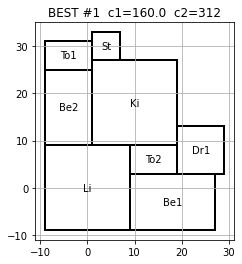

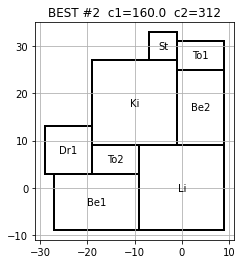

In [57]:
sizes = {
    "Li": (18,18),
    "Ki": (18,18),
    "Be1": (18,12),
    "Be2": (10,16),
    "Dr1": (10,10),
    "To1": (10,6),
    "To2": (10,6),
    "St": (6,6)
}

adjacency = {
    "Li": ["Ki","Be1","Be2"],
    "Ki": ["Li","Be2","St"],
    "Be1": ["Li","Dr1","To2"],
    "Be2": ["Li","Ki","To1"],
    "Dr1": ["Be1","To2"],
    "To2": ["Be1","Dr1"],
    "To1": ["Be2"],
    "St": ["Ki"]
}


direction_constraints = {
    "Li": {"forbid":["S"]},
}

best, paths = solve_floorplan(sizes, adjacency, direction_constraints)


for i,(c1,c2,layout,key) in enumerate(best):
    plot_layout(sizes, layout, f"BEST #{i+1}  c1={c1}  c2={c2}")


# c1, c2, layout, key = best[0]
# path = paths[key]

# print("BEST layout cost1=", c1, " cost2=", c2)

# for i, step in enumerate(path):
#     plot_layout(sizes, step["centers"], f"Step {i}")

In [38]:
def extract_step_rule(prev_centers, new_centers, sizes, adjacency):
    """
    prev_centers: 이전 step의 centers
    new_centers : 현재 step의 centers
    """
    # 새로 등장한 방 찾기
    new_rooms = [r for r in new_centers if r not in prev_centers]
    if not new_rooms:
        return None   # 첫 스텝인 경우

    R = new_rooms[0]  # 이번 스텝에서 배치된 방
    Rx, Ry = new_centers[R]
    w2, h2 = sizes[R]

    # 어떤 host room 붙어서 생성됐는지 찾기
    attached = None
    direction = None

    for H in prev_centers:
        Hx, Hy = prev_centers[H]
        w1, h1 = sizes[H]

        r1 = rect_from_center(Hx,Hy,w1,h1)
        r2 = rect_from_center(Rx,Ry,w2,h2)

        if positive_edge_touch(r1,r2):
            attached = H

            # 방향 계산
            if abs((Hx + w1/2) - (Rx - w2/2)) < 1e-9:
                direction = "E"
            elif abs((Hx - w1/2) - (Rx + w2/2)) < 1e-9:
                direction = "W"
            elif abs((Hy + h1/2) - (Ry - h2/2)) < 1e-9:
                direction = "N"
            elif abs((Hy - h1/2) - (Ry + h2/2)) < 1e-9:
                direction = "S"
            break

    if attached is None:
        return None

    rule = f"({attached}_{sizes[attached][0]}_{sizes[attached][1]})-({R}_{w2}_{h2})-({direction})"
    return {"Room": R,
            "Host": attached,
            "Size": f"{w2}x{h2}",
            "Adjacency": f"{attached}-{R}",
            "Direction": direction,
            "Rule": rule}


In [39]:
def save_plot_layout(sizes, centers, filename):
    fig, ax = plt.subplots(figsize=(6,4))

    xs=[]; ys=[]
    for k,(cx,cy) in centers.items():
        w,h = sizes[k]
        xs += [cx-w/2, cx+w/2]
        ys += [cy-h/2, cy+h/2]

    pad=2
    ax.set_xlim(min(xs)-pad, max(xs)+pad)
    ax.set_ylim(min(ys)-pad, max(ys)+pad)
    ax.set_aspect("equal")
    ax.grid(True)
    ax.set_title(filename)

    for k,(cx,cy) in centers.items():
        w,h=sizes[k]
        ax.add_patch(Rectangle((cx-w/2,cy-h/2),w,h,fill=False,lw=2))
        ax.text(cx,cy,k,ha='center',va='center')

    plt.savefig(filename + ".png")
    plt.close()


In [54]:
def build_rule_dataframe(path, sizes, final_centers, adjacency, direction_constraints, layout_id):
    rows = []
    all_rules = []

    os.makedirs("steps", exist_ok=True)

    Needs = {
        "Rooms": list(sizes.keys()),
        "Sizes": sizes,
        "Adjacency_Map": adjacency,
        "Direction_Constraints": direction_constraints
    }

    for i in range(len(path)):
        step = path[i]
        centers = step["centers"]
        prev = {} if i == 0 else path[i-1]["centers"]

        info = extract_step_rule(prev, centers, sizes, adjacency)

        # ---------- Rule 생성 ----------
        if info is None or "Rule" not in info:
            first_room = list(centers.keys())[0]
            w, h = sizes[first_room]
            rule_text = f"({first_room}_{w}_{h})"
        else:
            rule_text = info["Rule"]

        all_rules.append(rule_text)

        # ---------- 개별 step 이미지 저장 ----------
        step_num = i + 1
        image_path = f"steps/step_{layout_id}_{step_num}"
        save_plot_layout(sizes, centers, image_path)

        rows.append({
            "ID": 1,
            "Needs": Needs,
            "Step": step_num,
            "Step Rule": rule_text,
            "Step_Image": image_path + ".png",
            "Set_of_Rules": None,
            "Final_Layout_Image": None
        })

    # ---------- final layout 이미지 저장 ----------
    final_path = f"steps/final_layout{layout_id}"
    save_plot_layout(sizes, final_centers, final_path)
    final_image = final_path + ".png"

    # ---------- Set_of_Rules & Final Layout 모든 row 동일하게 적용 ----------
    for row in rows:
        row["Set_of_Rules"] = all_rules.copy()
        row["Final_Layout_Image"] = final_image

    return pd.DataFrame(rows)



In [55]:
all_dfs = []

for layout_id, (c1, c2, layout, key) in enumerate(best, start=1):
    path = paths[key]

    # layout_id 넘겨줌!!
    df_i = build_rule_dataframe(path, sizes, layout, adjacency, direction_constraints, layout_id)

    df_i["ID"] = 1
    df_i["Layout_ID"] = layout_id

    df_i["step_number"] = range(1, len(df_i) + 1)
    df_i["Step"] = df_i["Layout_ID"].astype(str) + "-" + df_i["step_number"].astype(str)

    df_i["Step_Image"] = "step" + df_i["Step"] + ".png"

    df_i["Path"] = c1
    df_i["Outline"] = c2

    final_cols = [
        "ID",
        "Needs",
        "Layout_ID",
        "Step",
        "Step Rule",
        "Step_Image",
        "Set_of_Rules",
        "Final_Layout_Image",
        "Path",
        "Outline"
    ]

    final_cols = [c for c in final_cols if c in df_i.columns]
    df_i = df_i[final_cols]

    all_dfs.append(df_i)

df_all = pd.concat(all_dfs, ignore_index=True)
df_all

# 저장
#df_all.to_csv("layout_steps_all.csv", index=False)


,ID,Needs,Layout_ID,Step,Step Rule,Step_Image,Set_of_Rules,Final_Layout_Image,Path,Outline
0,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",1,1-1,(Li_18_18),step1-1.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout1.png,168.0,324
1,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",1,1-2,(Li_18_18)-(Be2_18_12)-(E),step1-2.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout1.png,168.0,324
2,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",1,1-3,(Li_18_18)-(Ki_18_18)-(E),step1-3.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout1.png,168.0,324
3,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",1,1-4,(Li_18_18)-(Be1_18_12)-(N),step1-4.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout1.png,168.0,324
4,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",1,1-5,(Be2_18_12)-(To1_6_6)-(E),step1-5.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout1.png,168.0,324
5,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",1,1-6,(Ki_18_18)-(St_6_6)-(E),step1-6.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout1.png,168.0,324
6,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",1,1-7,(Be1_18_12)-(To2_12_6)-(W),step1-7.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout1.png,168.0,324
7,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",1,1-8,(Li_18_18)-(Dr1_12_12)-(W),step1-8.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout1.png,168.0,324
8,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",2,2-1,(Li_18_18),step2-1.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout2.png,168.0,324
9,1,"{'Rooms': ['Li', 'Ki', 'Be1', 'Be2', 'Dr1', 'T...",2,2-2,(Li_18_18)-(Be2_18_12)-(E),step2-2.png,"[(Li_18_18), (Li_18_18)-(Be2_18_12)-(E), (Li_1...",steps/final_layout2.png,168.0,324
